In [3]:
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data Preprocessing and Exploration Part I

In this part, we will use our processed data from Part I and implement unsupervised learning with visualization while identifying interesting structure.


## Unsupervised Learning includes (Part I  & II):
1. Visualizatioin - data distribution (historgrams, density plot) (Part I  & II)
2. Visualizatioin - for individual features and their relationship with target value (Part II)
3. Visualizatioin - Correlation Matrix between Features (Part II)
4. Pattern Exploration - clustering & dimensionality (PCA) (Part II)

## Interesting Structure (Part I  & II):
With some domain knowledge, we have the following interesting findings:

not helpful to use symbol_id and time_id?
lags?

## Referred Notebook in this part:

https://www.kaggle.com/code/vroger11/quick-dataset-analysis-and-suggestions

https://www.kaggle.com/code/kevinlam/2024-jane-street-preprocessing-public

https://www.kaggle.com/code/mpwolke/plotting-on-jane-street

https://www.kaggle.com/code/shiyili/js2024-rmf-understanding-the-data

https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting/discussion/548636

https://www.kaggle.com/code/michau96/jane-street-features-by-financial-instruments

# Loading Processing Data

In [4]:
df_scaled = pd.read_csv("/kaggle/input/sampled-data-js/df_miss_outliers_replaced_scaled.csv")

# Clustering Analysis - Kmeans

We determine the optimal number of clusters using the Elbow method

In [7]:
# put the scaled only data to cluster

sse1 = []
for k in range(1, 11):  # Testing 1 to 10 clusters
    print("starts loop: ", k)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_scaled)
    sse1.append(kmeans.inertia_)

starts loop:  1
starts loop:  2
starts loop:  3
starts loop:  4
starts loop:  5
starts loop:  6
starts loop:  7
starts loop:  8
starts loop:  9
starts loop:  10


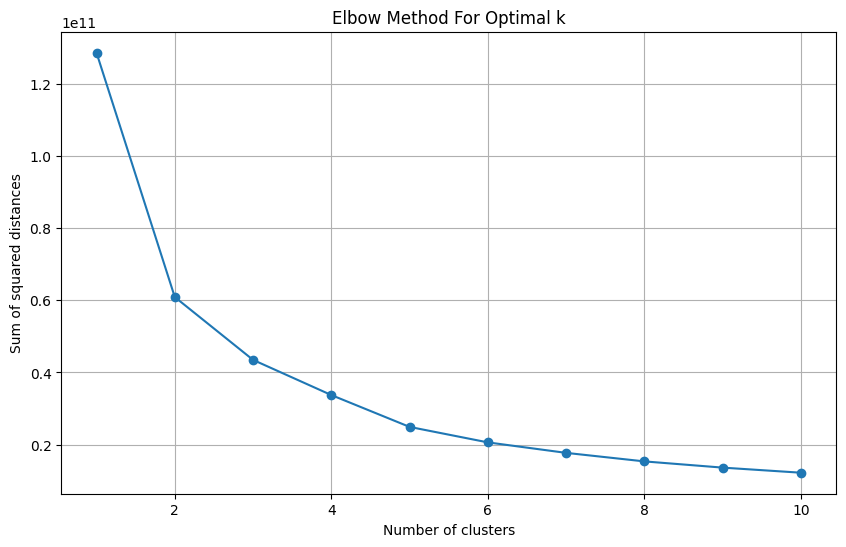

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse1, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()

By the elbow method, we determin than K = 2 will be a good number of clusters for out dataset.

In [14]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(df_scaled)

df_scaled['cluster'] = clusters

# Count the number of data points in each cluster
cluster_counts = df_scaled['Cluster'].value_counts()
cluster_counts


Cluster
1    276071
0    195415
Name: count, dtype: int64

## Visualize the Cluster with Respect to Date_id

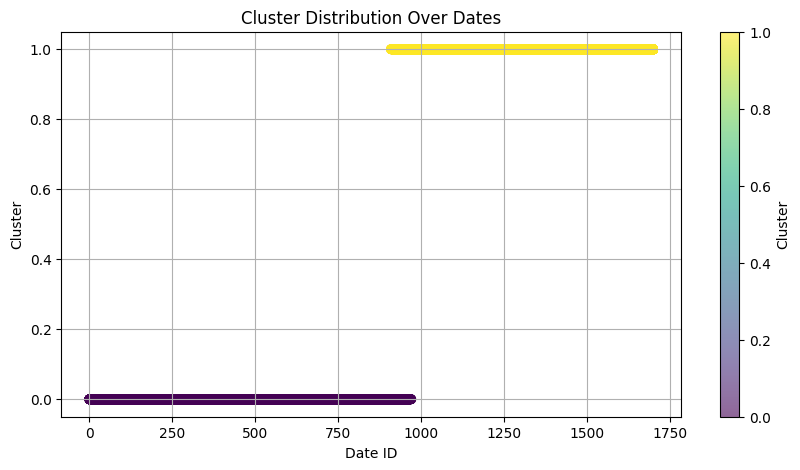

In [18]:
plt.figure(figsize=(10, 5))
plt.scatter(df_scaled['date_id'], df_scaled['cluster'], alpha=0.6, c=df_scaled['cluster'], cmap='viridis')
plt.title('Cluster Distribution Over Dates')
plt.xlabel('Date ID')
plt.ylabel('Cluster')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


## Getting the First Date_id of Cluster 1

In [17]:
cluster_ones = df_scaled[df_scaled['cluster'] == 1]

# Find the smallest 'date_id' in this filtered DataFrame
first_one_date_id = cluster_ones['date_id'].min()

print(f"The first occurrence of cluster 1 is on date_id {first_one_date_id}")

The first occurrence of cluster 1 is on date_id 908


In [45]:
# out put the clustered data
df_scaled.to_csv('clustered_data.csv', index=False)

## Summary from Clustering

Our data are separated into 2 clusters. After observing the cluster distribution with respect to date_id, we have the following guessing:

1. Features have different pattern in 2 period of times
2. Since this is a time-series data, this distribution is a sign of a continuous change overtime.

# PCA

In [28]:
feature_columns = [col for col in df_scaled.columns if 'feature' in col]
df_features = df_scaled[feature_columns]

pca = PCA(n_components=2)  # Adjust this number as per your analysis requirement
principal_components = pca.fit_transform(df_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

Explained Variance Ratio: [0.110073   0.08981722]


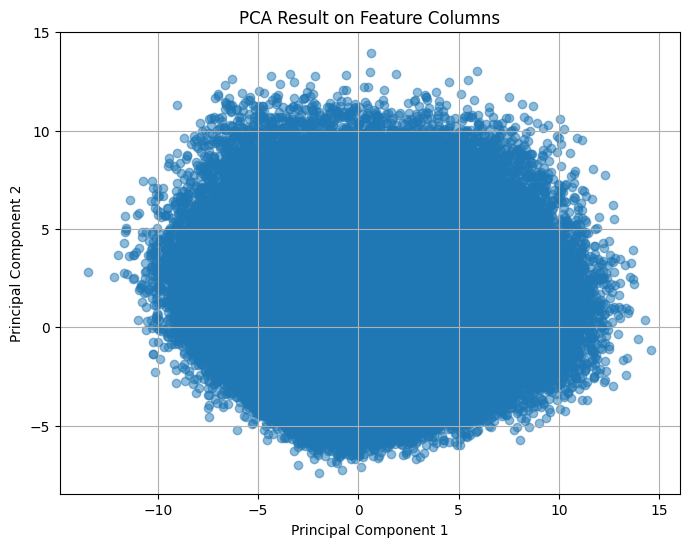

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.title('PCA Result on Feature Columns')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [30]:


pca = PCA(n_components=3)  # Adjust this number as per your analysis requirement
principal_components = pca.fit_transform(df_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

Explained Variance Ratio: [0.110073   0.08981722 0.0792936 ]


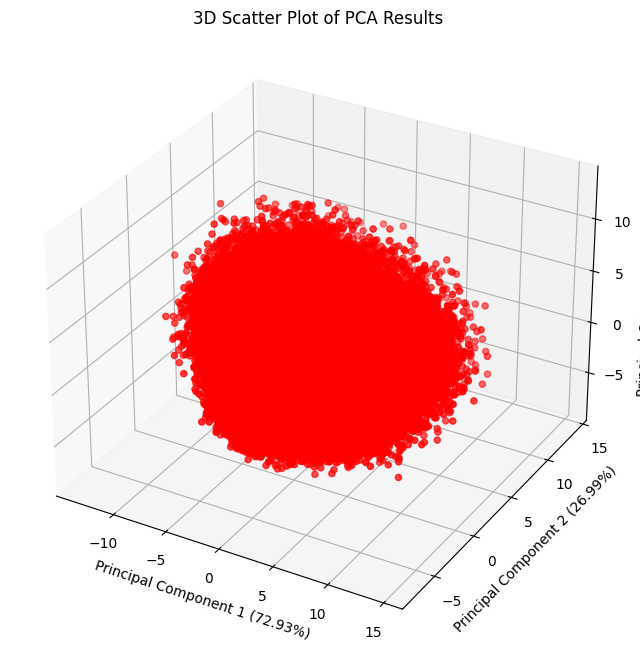

In [31]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c='r', marker='o')

# Labeling the axes
ax.set_xlabel('Principal Component 1 (72.93%)')
ax.set_ylabel('Principal Component 2 (26.99%)')
ax.set_zlabel('Principal Component 3 (4.62%)')

# Title
ax.set_title('3D Scatter Plot of PCA Results')

plt.show()

## Observation from PCA 
The data points form an elongated, somewhat circular distribution, stretching diagonally from the bottom-left to the top-right. This suggests that there is a linear relationship between PC1 and PC2 for a significant portion of your data, as the points tend to spread along a line or curve.

Principal Component 1 (PC1) appears to capture most of the variability, with data points spread widely along this axis.

There isn't a clear clustering of data into distinct groups, which could mean that the data does not have distinct, separable groups based on these two or three components

# Density Plots

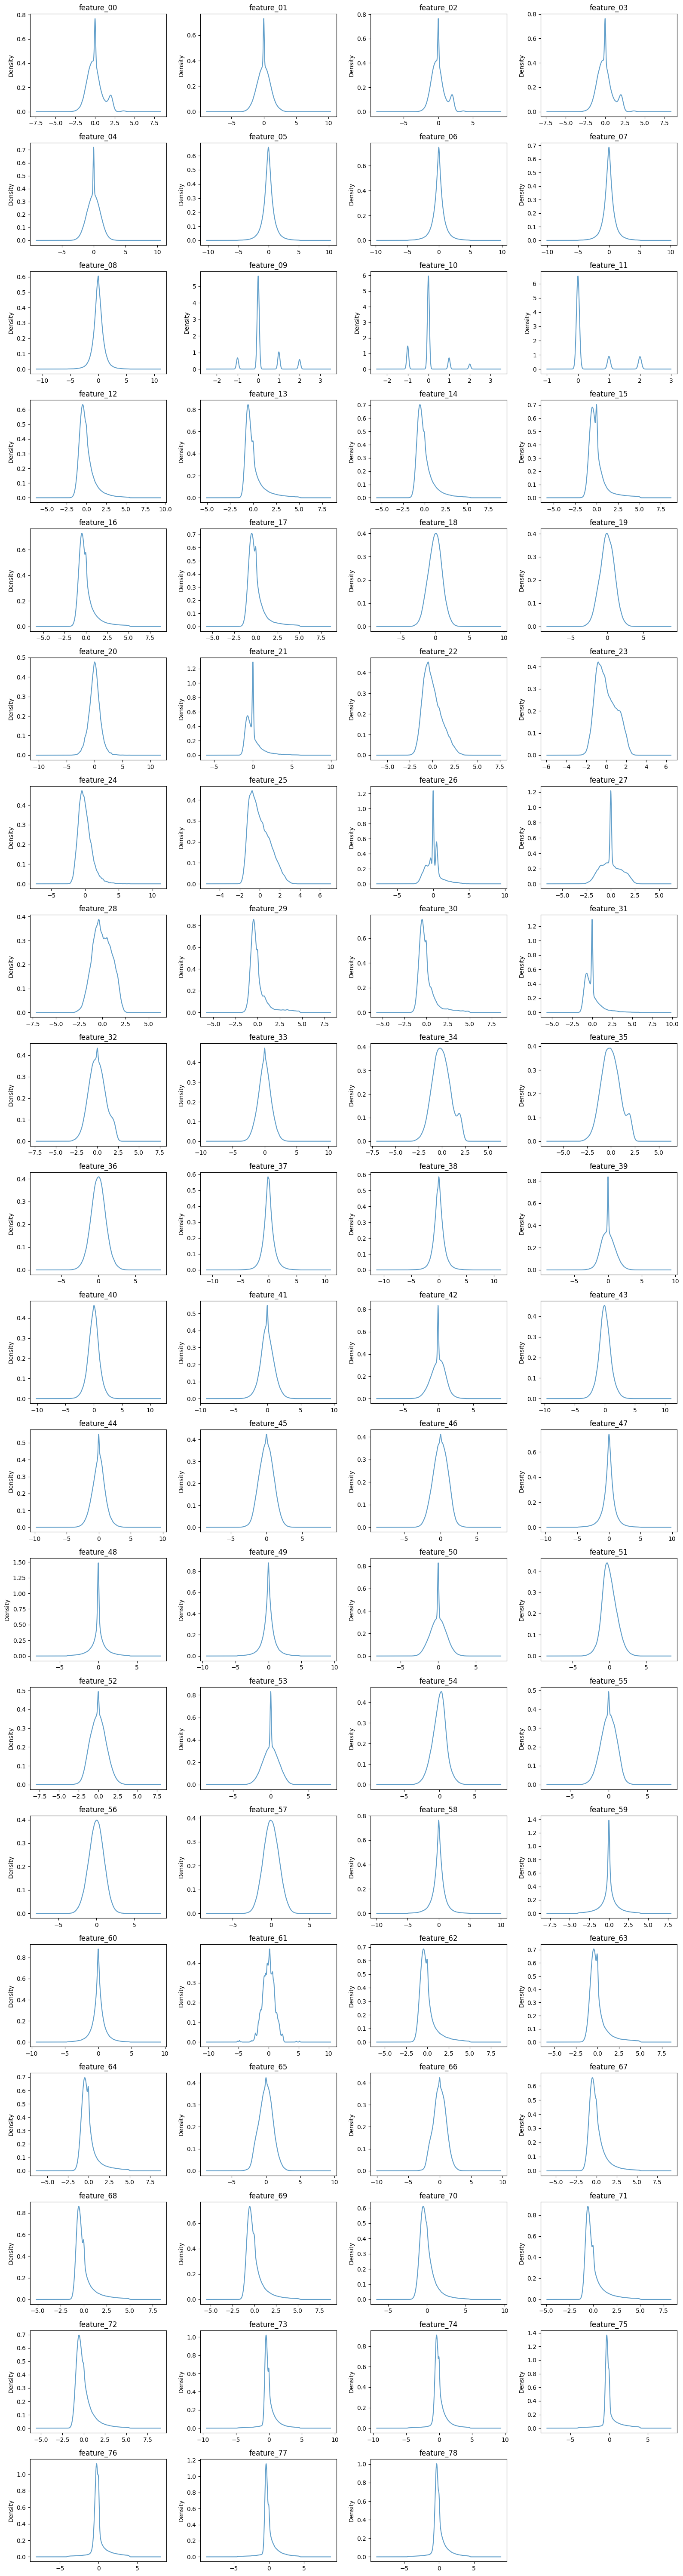

In [34]:
feature_labels = [col for col in df_scaled.columns if col.startswith('feature_')]

# Calculate the number of rows and columns for the subplot grid
n_cols = 4  # Number of columns
n_rows = (len(feature_labels) + n_cols - 1) // n_cols  # Calculate the number of rows needed

plt.figure(figsize=(n_cols * 4, n_rows * 3))  # Adjust overall figure size based on the number of subplots

# Create a density plot for each feature
for i, feature_label in enumerate(feature_labels):
    plt.subplot(n_rows, n_cols, i + 1)  # Create a subplot for each feature
    df_scaled[feature_label].plot(kind='density', alpha=0.7)  # Density plot for the feature
    plt.title(feature_label)
    plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

In [ ]:
df_scaled['feature_00'].plot(kind='density')
plt.title('Density Plot of feature_00')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

# Visualize Each Feature with the Target

The scatter plots give the following indication:

1. feature 09, 10, 11 are encoded categorical data;
2. there is no simple linear relationships
3. some scatter plot are in a rounded shape. We can use polynomial transformation

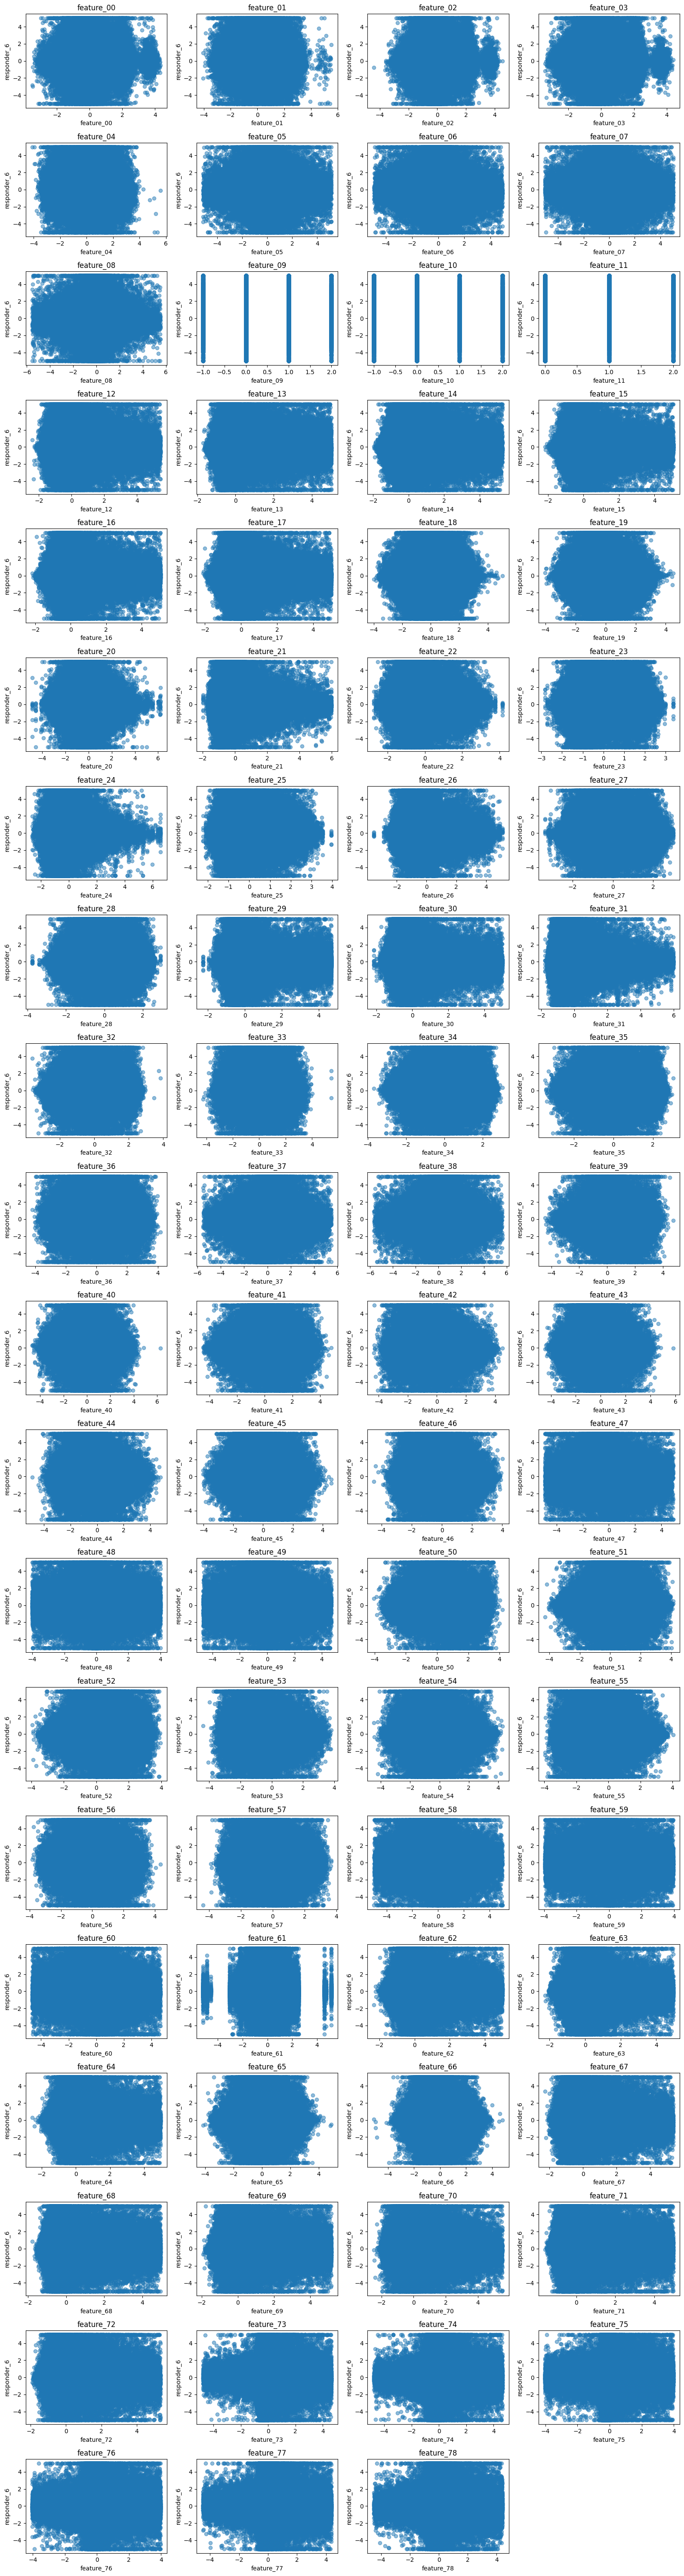

In [36]:
feature_labels = [col for col in df_scaled.columns if col.startswith('feature_')]

# Calculate the number of rows and columns for the subplot grid
n_cols = 4  # Number of columns
n_rows = (len(feature_labels) + n_cols - 1) // n_cols  # Calculate the number of rows needed

plt.figure(figsize=(n_cols * 4, n_rows * 3))  # Adjust overall figure size based on the number of subplots

# Create a scatter plot for each feature against responder_6
for i, feature_label in enumerate(feature_labels):
    plt.subplot(n_rows, n_cols, i + 1)  # Create a subplot for each feature
    plt.scatter(df_scaled[feature_label], df_scaled['responder_6'], alpha=0.5)  # Scatter plot of the feature vs responder_6
    plt.title(feature_label)
    plt.xlabel(feature_label)
    plt.ylabel('responder_6')
    plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

# Correlation Matrix

In [37]:
feature_columns = [col for col in df_scaled.columns if col.startswith('feature_')]
features_df = df_scaled[feature_columns]

# Compute the Pearson correlation matrix
corr_matrix = features_df.corr()

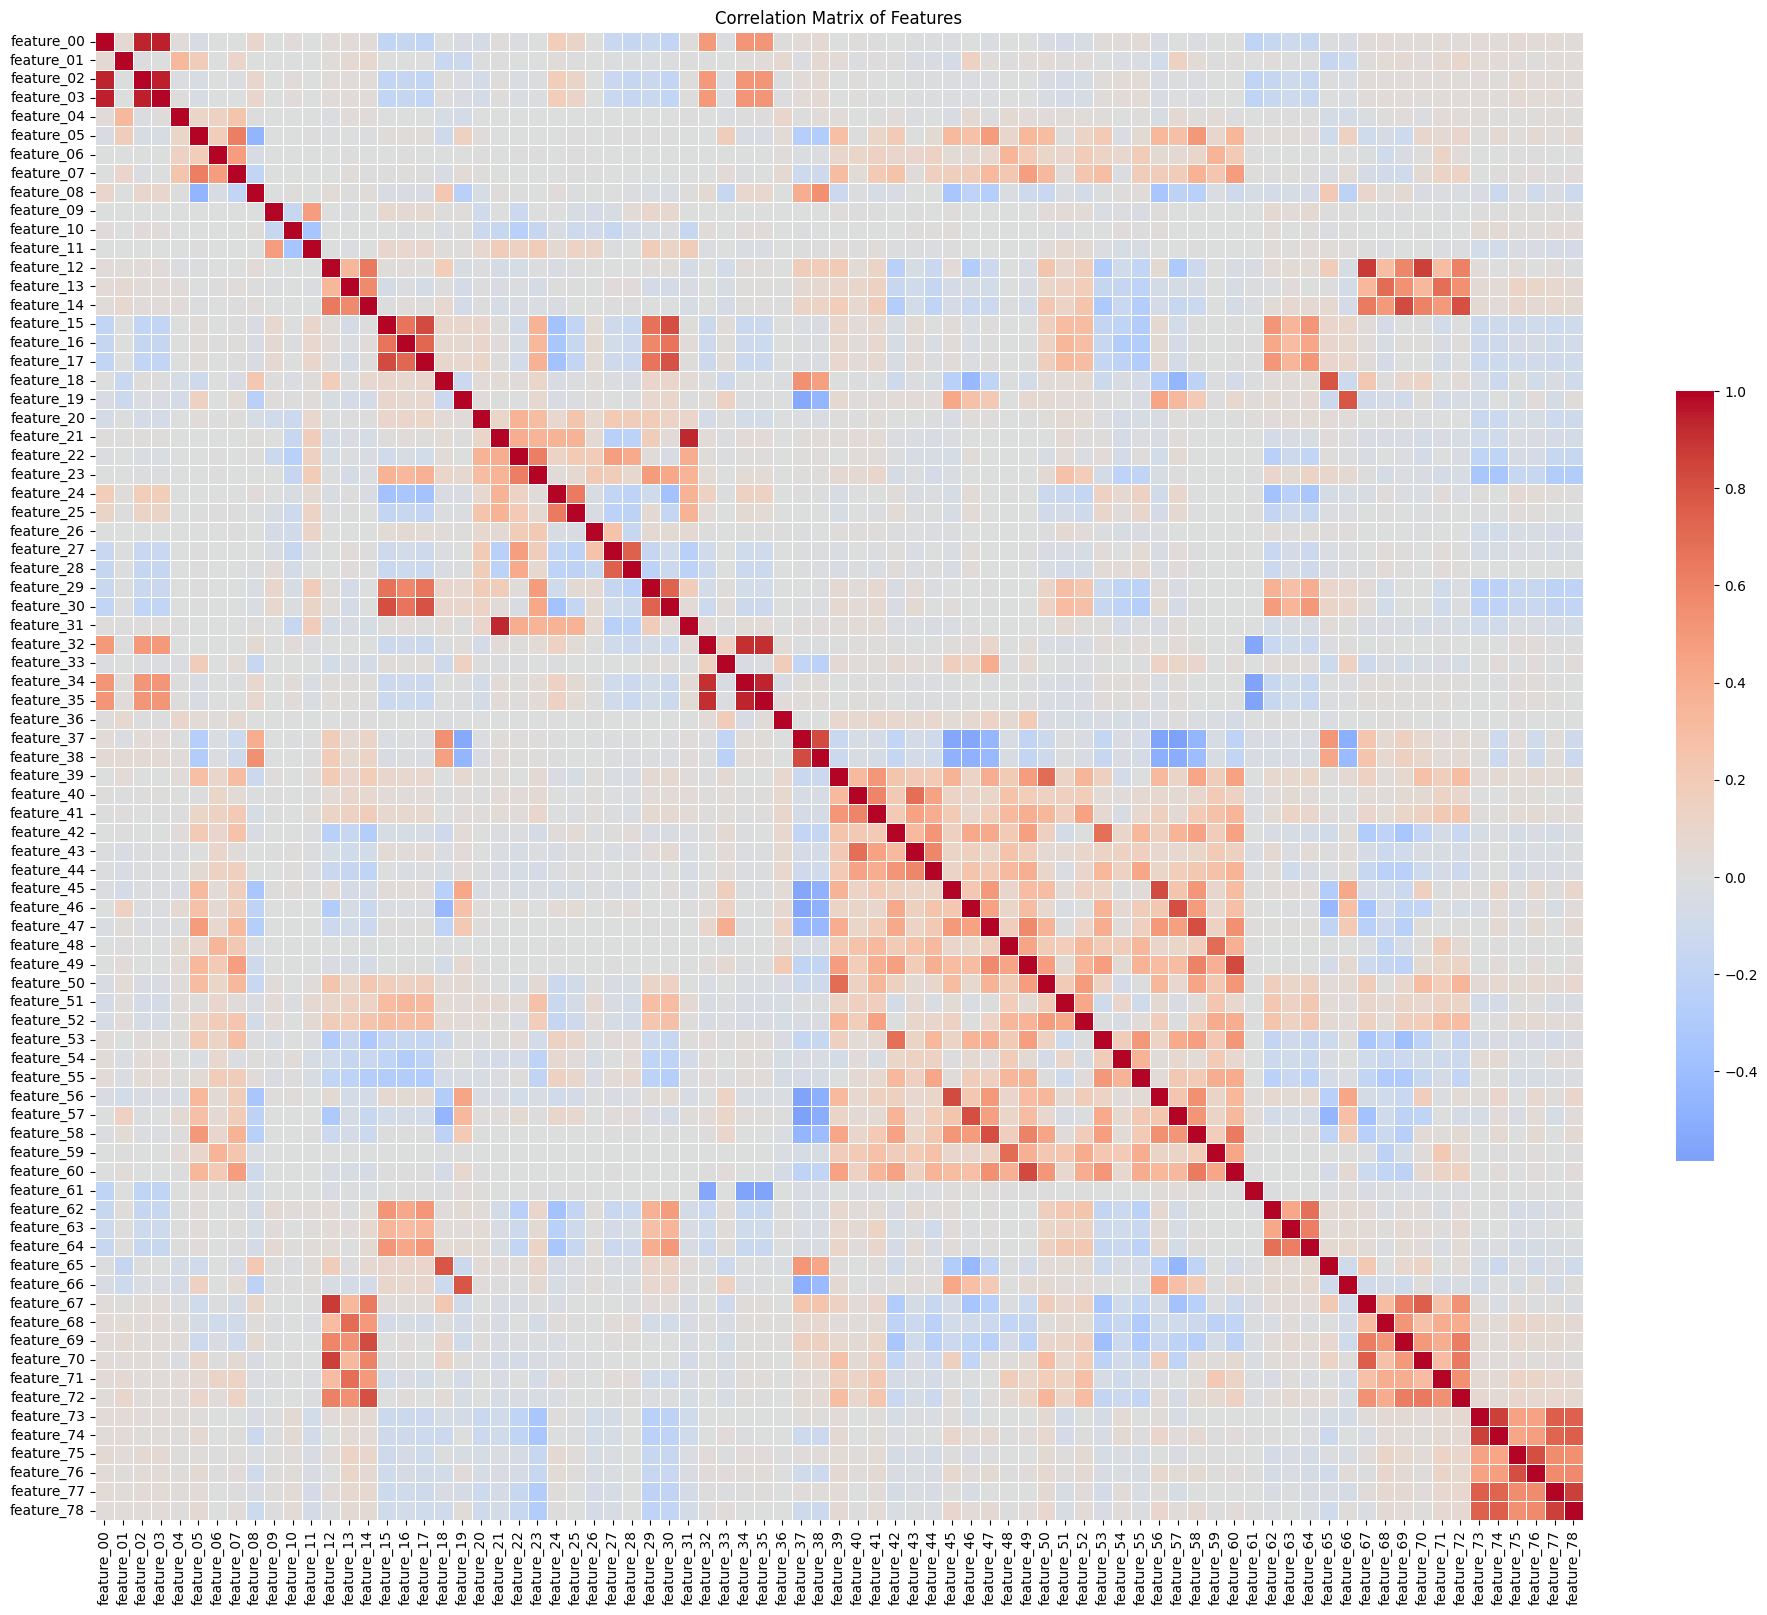

In [42]:
plt.figure(figsize=(24, 20))  # Larger figure size to accommodate all features

# Draw the full heatmap without a mask and with optional annotations
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add titles and labels for clarity
plt.title('Correlation Matrix of Features')
plt.xticks(rotation=90)  # Rotate feature labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability

plt.show()

In [43]:
threshold = 0.8  # Set the correlation threshold

# Find pairs of highly correlated features
# Using `np.triu_indices_from` to iterate over upper triangle of correlation matrix, excluding the diagonal
high_corr_pairs = [(corr_matrix.columns[i], corr_matrix.columns[j])
                   for i, j in zip(*np.triu_indices_from(corr_matrix, k=1))
                   if abs(corr_matrix.iloc[i, j]) > threshold]

# Convert the list of tuples into a DataFrame for better visualization
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2'])
high_corr_df['Correlation'] = [corr_matrix.iloc[i, j] for i, j in zip(*np.triu_indices_from(corr_matrix, k=1))
                               if abs(corr_matrix.iloc[i, j]) > threshold]

high_corr_df

Feature 1   Feature 2  Correlation
0   feature_00  feature_02     0.943807
1   feature_00  feature_03     0.945857
2   feature_02  feature_03     0.947548
3   feature_12  feature_67     0.876071
4   feature_12  feature_70     0.862875
5   feature_14  feature_69     0.823701
6   feature_14  feature_72     0.807690
7   feature_15  feature_17     0.821089
8   feature_15  feature_30     0.809970
9   feature_21  feature_31     0.930829
10  feature_32  feature_34     0.909946
11  feature_32  feature_35     0.914050
12  feature_34  feature_35     0.943466
13  feature_37  feature_38     0.824361
14  feature_45  feature_56     0.825425
15  feature_46  feature_57     0.814879
16  feature_47  feature_58     0.809230
17  feature_49  feature_60     0.830737
18  feature_73  feature_74     0.861515
19  feature_75  feature_76     0.815475
20  feature_77  feature_78     0.858338

## Indications from Correlation Matrix:

For these highly correlated features, we might:

1. consider removing some of them from out model to reduce multicollinearity
2. add regularization (Lasso, Ridge) to reduce the impact of less important features
3. create new features that are combinations of highly correlated ones